# Report on the main functionalities implemented in the prototype

Here I will walk through the functionalities implemented so far.
It is all representative, which means that terminology and details might not correspond completely to the final version and what we have envisioned.
While hacking away, I was also thinking about the design and how to make it more modular and extensible.
Sometimes I also changed some things in the design (mainly affecting implementation-level details) and I will try to explain the reasoning behind them.
Please let me know if I changed some things too much!
I was heavily focusing on the modular aspects, so I might have glossed over some important things we have agreed on before.

I believe that my next targets should be:

1. Documentation (before I forget what I did)
2. Automated testing (develop unit tests while it is still easy to do so)
3. Make the design and terminology more consistent with the planned final version
3. Refactoring and Performance Improvement (implement parallelism, optimize the code, etc.)
4. Extending the functionality (implement the missing features, such as model recovery, etc.)

...in this order.

## Keeping track of the state

I have created a Notion database to track progress and issues in the project.
I will try to keep it up to date and also import all the things from the Engineering Document that are still waiting to be done.
I will send an invite to the database as soon as I have the time to do so and it is in a presentable format.
It would be immensely helpful if you could add any tasks and issues to the database as well.

Keep in mind, that there are things that might have been implemented but are not working as expected.
This is something I am aware of and working on at the moment.
If you notice something weird, please let me know and/or add it to the database.

## The toolbox

Okay, so let's start with the toolbox.
First things first, CPM is the winner as the name of the toolbox. :smile:

### The toolbox structure

The toolbox is structured as a collection of modules.
Each module is a separate folder in the `cpm` folder.
The way you import the modules is by typing `import cpm.<module_name>`.
Currently, the toolbox is not compiled, which means that you have to have the folder in your current working directory.
It is on my to-do list to compile the toolbox and make it installable via `pip`.
The modules are:

    - `cpm.utils`: A module that contains utility functions and classes.
    - `cpm.models`: A module that contains the model components and associated wrapper functions.
    - `cpm.models.zoo`: A submodule of models that contains all model components categorised as activation, attention, decision, learning, memory, utils, and etc.
    - `cpm.applications`: A module that contains fully implemented working models from e.g. previous publications.
    - `cpm.optimisation`: A module that contains the optimisation routines and various goodness-of-fit metrics.
    - `cpm.evaluation`: A module that contains the evaluation routines.

Most functions will take in a python dictionary as an input and return a python dictionary or an array as an output.
The reason for this is that it is easier to keep track of the inputs and outputs and it is also easier to make it modular.
Dictionaries are key-value pairs, which means that you can easily add new parameters without breaking the code.
This also allows components to interact with each other without knowing the details of the other component, as they simply pull a value according to its name, `key`.
The downside is that it is a bit slower than using arrays, but it is negligible as almost all computations will use `numpy` arrays.

Note that in python, lists and arrays are pretty much mean the same thing.


### Creating Models

The models are created by instantiating the `Model` class from the `cpm.models` module.

In [9]:
from cpm.models import Model, Wrapper
# import components we want to use
from cpm.models.zoo.activation import LinearActivation
from cpm.models.zoo.decision import Softmax
from cpm.models.zoo.learning import DeltaRule

# import some useful stuff
from prettyformatter import pprint as pp ## pretty print
import numpy as np


Here, we will create a model with a single activation component, a single decision component, and a single learning component.
This will be the model that we iterate over each trial, which means that this compiled model will only calculate the output for a single trial.

In [10]:
costum = Model(functions = [LinearActivation, Softmax, DeltaRule])

## create a single trial as a dictionary

trial = {
    'alpha' : 0.1,
    'temperature': 1,
    'weights' : np.array([[0.5, 0.1], [0, 0.5]]),
    'input' : np.array([0, 1]),
    'feedback' : np.array([0, 1]),
    'attention' : np.array([1, 0]),
    'misc' : np.array([1, 0])
    }

## run the model on the trial (** unpacks the dictionary)
costum.compute(**trial)
pp(costum.policy)

array([0.44283102, 0.55716898])


This is a very simple model with some very simple components and output.
We can also export some details about the model to learn what is going on under the hood.
This is where we need to store all metadata as well (including bounds and priors - not yet implemented).

In [12]:
costum.summary()

{'activation': 'Linear',
 'decision': 'Softmax',
 'learning': 'DeltaRule',
 'shape': (2, 2),
 'variables': 4}

This is neat. We can see that the model has 3 components, each with its own name and category.
We also have the shape, which is the shape of the value/weight matrix, where rows are outcomes/actions and columns are stimuli.
The variables are the number of internal variables the model calculates (I think that they are simply called parameters in Deep Learning as compared to hyperparameters like learning rate).

Let's look at these variables.

In [14]:
pp(costum.weights)

array([[0.5 , 0.04],
       [0.  , 0.55]])


It would not be a bad idea to have a function that prints out the model structure in a nice way, perhaps indented and with some nice ASCII stuff or maybe even visualize it.
For now, this is enough I think.

Another thing we can do is to export model components and their output to a dictionary.

In [15]:
pp(costum.values)

{
    "Linear":
        array([[0. , 0.1],
       [0. , 0.5]]),
    "Softmax"   : array([0.44283102, 0.55716898]),
    "DeltaRule":
        array([[0.5 , 0.04],
       [0.  , 0.55]]),
}


This is all great but we also need to be able to save the model to a file and load it back.
This is currently not implemented, but the way we will do it is by using the `pickle` library.

In [19]:
import pickle as pkl

pkl.dump(costum, open("mine.pkl", "wb"))
pickled_model = pkl.load(open("mine.pkl", "rb"))

pickled_model.policy
pp(pickled_model.values)
pickled_model.summary()

{
    "Linear":
        array([[0. , 0.1],
       [0. , 0.5]]),
    "Softmax"   : array([0.44283102, 0.55716898]),
    "DeltaRule":
        array([[0.5 , 0.04],
       [0.  , 0.55]]),
}


{'activation': 'Linear',
 'decision': 'Softmax',
 'learning': 'DeltaRule',
 'shape': (2, 2),
 'variables': 4}

### Run the model on data

Let us start by defining some parameters.
We will define them in a dictionary, which allows the Model and Wrapper classes to pull the parameters they need by name.
So you don't have to create different objects for each model, you can simply input the same dictionary to all models and they will pull the parameters they need.
You don't even need to subset them.

In [20]:
params = {  # define the parameters
    "alpha": 0.25,
    "temperature": 5,
}

The next bit will be defining the experiment. It will require a bit of explanations so here we go.

The experiment is a dictionary that contains all the information about the experiment that the **model** needs to run.
Some models will require more information than others, but the basic information is the same.

- `trials`: It is a 2D array where the first dimension represents the trial and the second dimension represents for example in which order the stimuli is presented. If you have stimulus 2 and stimulus 3 presented on trial 1, then the first row will be `[2, 3]`. If you have stimulus 1 and stimulus 3 presented on trial 2, then the second row will be `[1, 3]`. This will look like `[[2, 3], [1, 3]]` This is the only thing that is required for all models.
- `feedback`: It is (currently) a 1D array where the first dimension represents the trial and the value represents the feedback. If you have feedback 1 on trial 1 and feedback 0 on trial 2, then the array will be `[1, 0]`. This will look like `[1, 0]`. This is required for all models that have a learning component.

In [21]:
data = {
        "trials": np.array([[2, 3], [1, 4], [3, 2], [4, 1], [2, 3], [2, 3], [1, 4], [3, 2], [4, 1], [2, 3]]),
        "feedback": np.array([1, 2, 1, 2, 1, 1, 2, 1, 2, 1]),
}

The next bit that we can do is to use the `Wrapper` class to run the model on a single experiment.
This object will take in the model, the parameters, and the experiment and will run the model on the experiment using the parameters.

In [25]:
complete = Wrapper(model = costum, data = data, params = params)
## run the model
complete.run()
## print the policies: first dimension is the trial, second dimension is the action
pp(complete.policies)

array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.69184987, 0.30815013],
       [0.25478962, 0.74521038],
       [0.86589453, 0.13410547],
       [0.94655136, 0.05344864],
       [0.11158493, 0.88841507],
       [0.96622208, 0.03377792],
       [0.03927633, 0.96072367],
       [0.98442384, 0.01557616]])


Awesome.
We can also use the export function to export the model output with the parameters to a dictionary.
The main difference between `export()` and `summary()` is that in the long run `export()` will contain more metadata and will allow to export to a JSON file.

In [24]:
pp(complete.export())


{
    "weights":
        array([[-0.66503906,  1.00341797,  1.00341797, -0.66503906],
       [ 0.82617188, -0.66503906, -0.66503906,  0.82617188]]),
    "policies":
        array([[0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.69184987, 0.30815013],
       [0.25478962, 0.74521038],
       [0.86589453, 0.13410547],
       [0.94655136, 0.05344864],
       [0.11158493, 0.88841507],
       [0.96622208, 0.03377792],
       [0.03927633, 0.96072367],
       [0.98442384, 0.01557616]]),
    "name"  : "Model_3",
    "alpha" : 0.25,
    "temperature"   : 5,
}


In addition, we can also reset the model and rerun everything.
We could use the `Wrapper.reset()` function, that resets the weight/value matrices to the initial values.

### Optimisation

Now we have the model we want to use.
Let's create some data to fit the model to.

In [26]:
experiment = []
for i in range(100):
    ppt = {
        "ppt": i,
        "trials": np.array([[2, 3], [1, 4], [3, 2], [4, 1], [2, 3], [2, 3], [1, 4], [3, 2], [4, 1], [2, 3]]),
        "feedback": np.array([1, 2, 1, 2, 1, 1, 2, 1, 2, 1]),
        "observed": np.array([[1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]]),
    }
    experiment.append(ppt)

Compared to running the model on data, this is a bit more complicated.
Here we need to create a list of dictionaries, where each dictionary represents a single experiment a.k.a. a single participant.
Here I added two new key-value pairs to the experiment dictionary: `ppt` and `observed`.
`ppt` is the participant ID and `observed` is the observed response on each trial.
Here, I created it in the format the model outputs the policies: a 2D array where the first dimension represents the trial and the second dimension represents the action.
So they are essentially ones and zeros, because participants make binary decisions.

Okay, let's optimise the model.
We will use the `Optimiser` class to do so, and will use an Evolutionary/genetic algorithm.
The optimiser will take in the compiled model and wrapper, the data, and the bounds.
Now, here the data will also include trial-level details, such as the stimuli and feedback.

In [34]:
from cpm.optimisation import DifferentialEvolution, minimise

lower = [1e-10, 1e-10]
upper = [1, 10]
bounds = list(zip(lower, upper))

# NOTE: there is something strange going on here, but please ignore it for now, I am working on this
Fit = DifferentialEvolution(
    model = complete, bounds = bounds, data = experiment, minimisation="LogLikelihood", mutation = 0.5, recombination = 0.7, strategy = "best1bin", tol = 0.001
)
## look at the NLL for a given set of parameters
## I think there is some stuff going on with 0 values as well - but I ignored it for now
Fit.minimise([0.60924690133760082, 5.6764639071806062])
Fit.optimise()

fittings = [item.get('fun') for item in Fit.fit]
pp(fittings)

[
    22.748305795706862,
    22.748305795706862,
    22.748305795706862,
    22.748305795706862,
    22.748305795706862,
    ...,
    22.748305795706862,
    22.748305795706862,
    22.748305795706862,
]


We can also look at the best fitting parameters here.
In principle, they should be the same because right new all participants are the same.

In [33]:
pp(Fit.parameters)

[
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
    ...,
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
    {"alpha": 0.017008084602395723, "temperature": 5.826488519449231},
]


This is great, so noew we can run the model on the best fitting parameters and see how it looks like.
We can use the `Simulator` class to do that, which takes in the data as defined above a list of dictionaries for the parameter.
I know that the Simulator was used a bit differently in what we outlined in the Engineering Document, but I think that this is still okay for now.

In [37]:
from cpm.models import Simulator

explore = Simulator(model = complete, data = experiment, parameters = Fit.parameters)
explore.run()


Let's look at the output.
We can simply export all the policies and 

In [38]:
pp(explore.policies())

array([[[0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.51269121, 0.48730879],
        ...,
        [0.55340794, 0.44659206],
        [0.45873449, 0.54126551],
        [0.56747525, 0.43252475]],

       [[0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.51269121, 0.48730879],
        ...,
        [0.55340794, 0.44659206],
        [0.45873449, 0.54126551],
        [0.56747525, 0.43252475]],

       [[0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.51269121, 0.48730879],
        ...,
        [0.55340794, 0.44659206],
        [0.45873449, 0.54126551],
        [0.56747525, 0.43252475]],

       ...,

       [[0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.51269121, 0.48730879],
        ...,
        [0.55340794, 0.44659206],
        [0.45873449, 0.54126551],
        [0.56747525, 0.43252475]],

       [[0.5       , 0.5       ],
        [0.5       , 0.5       ],
        [0.51269121, 0.48730879],
        .

### Evaluation

Alright, let us now try to do some parameter recovery.
There is less and less thing to explain now, so I will just go through it quickly.

We will use the `ParameterRecovery` class to do so.
This will take in the Wrapper, the optimiser, the strategy, bounds, and iterations.

In [46]:
from cpm.evaluation import ParameterRecovery

recover = ParameterRecovery(
    model = explore, optimiser = "DifferentialEvolution", strategy = "grid",
    bounds = bounds, iteration = 2
    )
recover.recover()

Okay, that was fairly quick.
Let's look at the results for the learning rate, which we can simply extract from the `ParameterRecovery` object.
NOTE that the model will have bad performance, but let's ignore that for now and focus on functionalities.

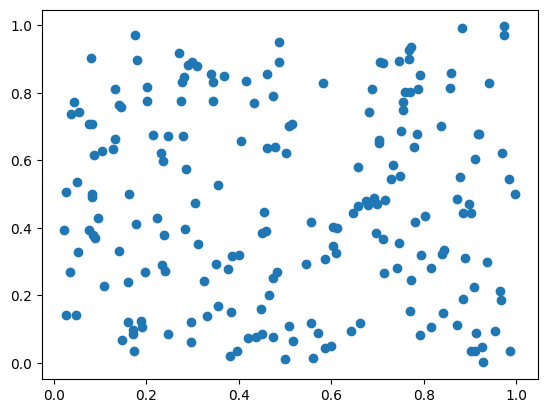

In [47]:
import matplotlib.pyplot as plt

alpha = recover.extract(key = 'alpha')

recovered = np.asarray(alpha[:, 0, :]).flatten()
original = np.asarray(alpha[:, 1, :]).flatten()

plt.scatter(recovered, original)
plt.show()

## The END

That's it for now.
There are some things that don't work as expected, but I am actively looking into them.
I think the biggest challenge was the modular aspect of the toolbox, but I think that it is working quite well now.